# Collaboration and Competition

---

This notebook trains a self-play DDPG agent to solve the Unity Tennis environment, where two agents learn to keep a ball in play over a net.

### 0. Install Dependencies

**Important**: The bundled Unity ML-Agents v0.4 package requires `protobuf==3.20.3`. If you encounter a `TypeError: Descriptors cannot be created directly` error, run the cell below to fix it, then restart the kernel.

In [ ]:
!pip install protobuf==3.20.3

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
from collections import deque
from maddpg_agent import Agent

%matplotlib inline

In [2]:
env = UnityEnvironment(file_name='Tennis.app')

In [3]:
# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Two agents control rackets to bounce a ball over a net:
- **Reward**: +0.1 for hitting the ball over the net, -0.01 if ball hits ground or goes out of bounds
- **Observation**: 24 dimensions per agent (3 stacked frames × 8 variables: ball/racket position and velocity)
- **Action**: 2 continuous values per agent (movement toward/away from net, jumping), each in [-1, 1]
- **Solve condition**: Average of max(agent1_score, agent2_score) >= 0.5 over 100 consecutive episodes

In [4]:
# Reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# Number of agents
num_agents = len(env_info.agents)
print(f'Number of agents: {num_agents}')

# Size of each action
action_size = brain.vector_action_space_size
print(f'Size of each action: {action_size}')

# Examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print(f'There are {num_agents} agents. Each observes a state with length: {state_size}')
print(f'The state for the first agent looks like:\n{states[0]}')

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like:
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]

### 3. Train the Agent

We use **self-play DDPG**: both agents share one actor, one critic, and one replay buffer. This works because Tennis is symmetric — an optimal policy for one side is optimal for the other.

Key adaptation from the Continuous Control project: **noise decay** (σ × 0.9995 per episode, with floor 0.01). In sparse-reward environments, the agent needs heavy exploration early but must quiet down once it finds a fragile cooperative equilibrium.

In [5]:
agent = Agent(state_size=state_size, action_size=action_size,
              num_agents=num_agents, random_seed=42)

In [6]:
n_episodes = 5000
max_t = 1000
all_scores = []
scores_window = deque(maxlen=100)
solved = False
t_start = time.time()

for i_episode in range(1, n_episodes + 1):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    agent.reset()
    scores = np.zeros(num_agents)

    for t in range(max_t):
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        agent.step(states, actions, rewards, next_states, dones)
        states = next_states
        scores += rewards
        if np.any(dones):
            break

    # Tennis scoring: max over the two agents
    episode_score = np.max(scores)
    all_scores.append(episode_score)
    scores_window.append(episode_score)
    rolling_avg = np.mean(scores_window)

    # Decay exploration noise
    agent.decay_noise()

    if i_episode % 100 == 0:
        elapsed = time.time() - t_start
        print(f'Episode {i_episode}\tAvg: {rolling_avg:.3f}\tNoise σ: {agent.noise_sigma:.4f}\t({elapsed:.0f}s)')

    if rolling_avg >= 0.5 and not solved:
        elapsed = time.time() - t_start
        print(f'\n*** Solved at episode {i_episode}!  100-ep avg: {rolling_avg:.3f} ({elapsed:.0f}s) ***')
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        solved = True
        break  # Stop training once solved

if not solved:
    print(f'\nDid not solve. Final 100-ep avg: {np.mean(scores_window):.3f}')
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

np.save('scores.npy', np.array(all_scores))

Episode 100	Avg: 0.004	Noise σ: 0.1903	(6s)
Episode 200	Avg: 0.005	Noise σ: 0.1812	(12s)
Episode 300	Avg: 0.004	Noise σ: 0.1725	(17s)
Episode 400	Avg: 0.000	Noise σ: 0.1643	(22s)
Episode 500	Avg: 0.000	Noise σ: 0.1565	(28s)
Episode 600	Avg: 0.001	Noise σ: 0.1491	(33s)
Episode 700	Avg: 0.000	Noise σ: 0.1420	(38s)
Episode 800	Avg: 0.004	Noise σ: 0.1353	(43s)
Episode 900	Avg: 0.001	Noise σ: 0.1289	(49s)
Episode 1000	Avg: 0.002	Noise σ: 0.1228	(54s)
Episode 1100	Avg: 0.004	Noise σ: 0.1170	(60s)
Episode 1200	Avg: 0.013	Noise σ: 0.1114	(68s)
Episode 1300	Avg: 0.155	Noise σ: 0.1044	(132s)

*** Solved at episode 1336!  100-ep avg: 0.510 (196s) ***

### 4. Plot Training Scores

Saved scores_plot.png


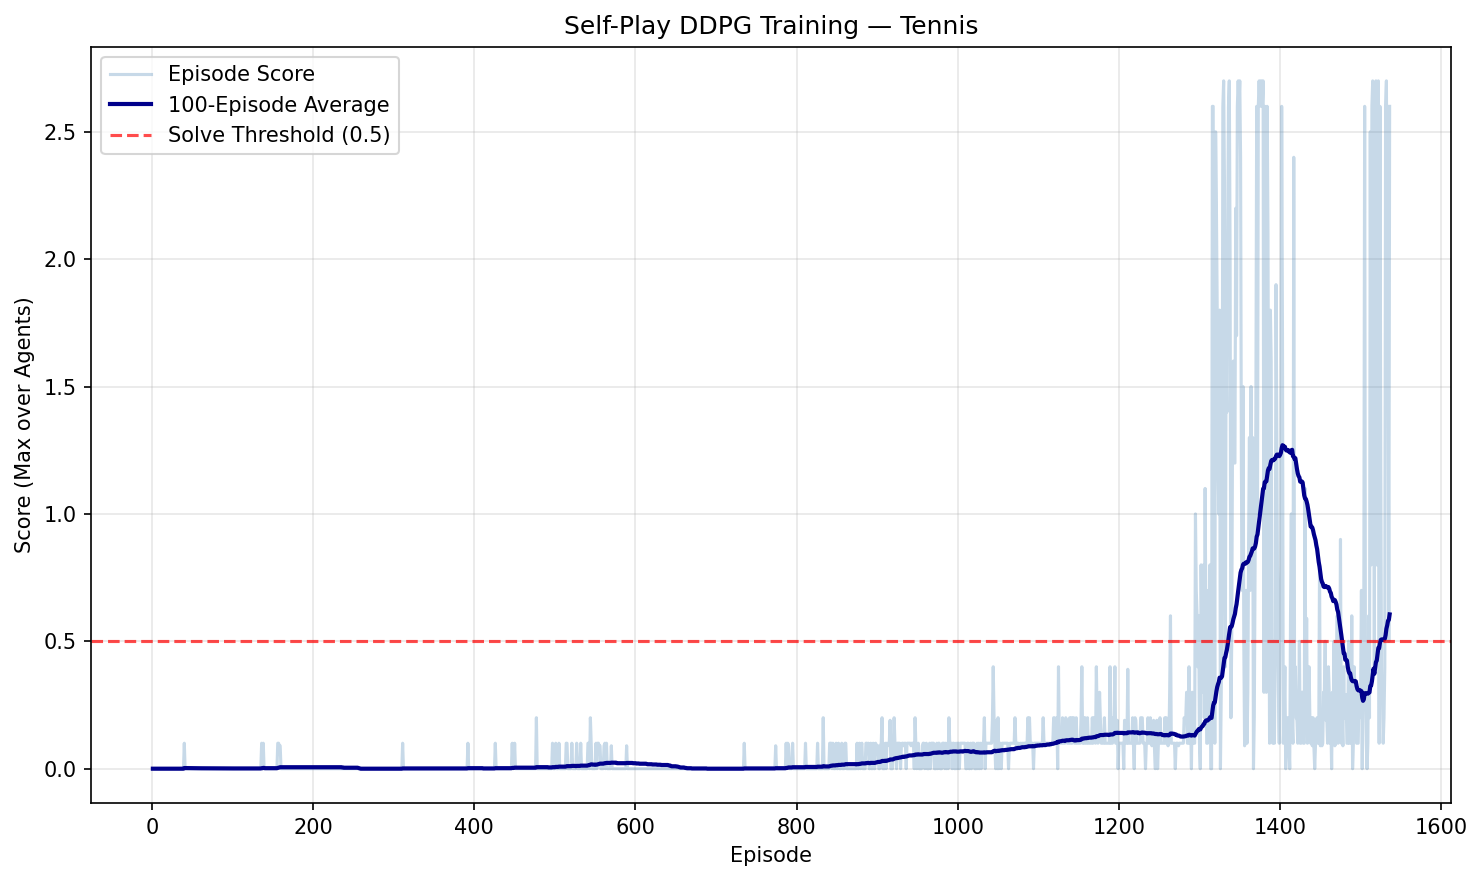

In [7]:
scores = np.load('scores.npy')

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.arange(1, len(scores) + 1), scores, alpha=0.3, color='steelblue', label='Episode Score')
if len(scores) >= 100:
    rolling = [np.mean(scores[max(0, i-100):i]) for i in range(1, len(scores) + 1)]
    ax.plot(np.arange(1, len(scores) + 1), rolling, color='darkblue', linewidth=2, label='100-Episode Average')
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Solve Threshold (0.5)')
ax.set_xlabel('Episode')
ax.set_ylabel('Score (Max over Agents)')
ax.set_title('Self-Play DDPG Training — Tennis')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('scores_plot.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved scores_plot.png')

### 5. Greedy Evaluation

In [8]:
# Load best checkpoint
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', weights_only=True))

test_scores = []
for i in range(1, 101):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    ep_scores = np.zeros(num_agents)
    while True:
        actions = agent.act(states, add_noise=False)
        env_info = env.step(actions)[brain_name]
        states = env_info.vector_observations
        ep_scores += env_info.rewards
        if np.any(env_info.local_done):
            break
    test_scores.append(np.max(ep_scores))
    if i % 20 == 0:
        print(f'Test {i}/100  Score: {np.max(ep_scores):.2f}')

print(f'\nGreedy Test Results (100 episodes):')
print(f'  Average: {np.mean(test_scores):.3f}')
print(f'  Std Dev: {np.std(test_scores):.3f}')
print(f'  Min:     {np.min(test_scores):.3f}')
print(f'  Max:     {np.max(test_scores):.3f}')

Test 20/100  Score: 2.60
Test 40/100  Score: 2.60
Test 60/100  Score: 2.70
Test 80/100  Score: 2.60
Test 100/100  Score: 2.60

Greedy Test Results (100 episodes):
  Average: 2.042
  Std Dev: 0.906
  Min:     0.000
  Max:     2.700

In [9]:
env.close()

---

## Report

### Learning Algorithm

This project implements **self-play DDPG (Deep Deterministic Policy Gradients)** for the Unity Tennis environment.

**DDPG** is an actor-critic algorithm for continuous action spaces:
- **Actor network** μ(s|θ^μ): Learns a deterministic policy mapping states to continuous actions.
- **Critic network** Q(s,a|θ^Q): Evaluates state-action pairs, providing gradient signal for the actor.

**Self-Play Architecture**: Since Tennis is symmetric, both agents share one actor network (and its target), one critic network (and its target), and one replay buffer. This doubles the effective experience rate.

**Target Networks** are updated via soft updates: `θ_target = τ · θ_local + (1 - τ) · θ_target` with τ = 0.001.

**Exploration Noise with Decay**: Ornstein-Uhlenbeck noise is added to actions for exploration. The noise sigma decays by 0.9995 per episode (from 0.2 to ~0.09 by episode 1500) with a floor of 0.01. This is critical for sparse-reward environments — the agent needs aggressive exploration early but must quiet down to maintain the fragile cooperative equilibrium.

#### Neural Network Architectures

**Actor**: `Input (24) → FC1 (128, ReLU) → FC2 (128, ReLU) → FC3 (2, Tanh)` — 19,970 parameters

| Layer | Parameters |
|---|---|
| FC1: 24 → 128 | 3,200 |
| FC2: 128 → 128 | 16,512 |
| FC3: 128 → 2 | 258 |
| **Total** | **19,970** |

**Critic**: `Input (24) → FC1 (128, ReLU) → [concat action (2)] → FC2 (130→128, ReLU) → FC3 (128→64, ReLU) → FC4 (64→1)` — 28,289 parameters

| Layer | Parameters |
|---|---|
| FC1: 24 → 128 | 3,200 |
| FC2: 130 → 128 | 16,768 |
| FC3: 128 → 64 | 8,256 |
| FC4: 64 → 1 | 65 |
| **Total** | **28,289** |

Actions are injected after the first hidden layer. No BatchNorm is used. Hidden layers use fan-in uniform initialization (±1/√fan_in); output layers use uniform(-3e-3, 3e-3).

#### Hyperparameters

| Parameter | Value | Rationale |
|---|---|---|
| Replay buffer size | 100,000 | Smaller than Reacher (2 agents vs. 20) |
| Batch size | 128 | Proportional to data availability |
| Discount factor (γ) | 0.99 | Standard; values future rewards highly |
| Soft update rate (τ) | 0.001 | Slow blending for target network stability |
| Actor learning rate | 1e-4 | Standard DDPG, Adam optimizer |
| Critic learning rate | 1e-3 | 10× actor LR (standard DDPG practice) |
| Learn every | 1 step | Only 2 agents producing transitions |
| Num updates | 1 | Single update per step |
| OU θ | 0.15 | Standard mean-reversion rate |
| OU σ (initial) | 0.2 | Standard noise scale |
| **Noise decay** | **0.9995/episode** | Reduces σ from 0.2 → ~0.09 by episode 1500 |
| **Noise floor** | **0.01** | Prevents noise from vanishing completely |
| Gradient clipping | 1.0 | Clips critic gradients to stabilize training |
| Max episodes | 5,000 | Patience for sparse rewards |

### Plot of Rewards

The plot above (Section 4) shows the max score across both agents per episode (light blue) and the 100-episode rolling average (dark blue). The environment was **solved at episode 1336**, when the 100-episode rolling average first exceeded 0.5.

**Training dynamics**: Scores remain near zero for the first ~1200 episodes as the agents explore randomly. Around episode 1200, individual scores begin spiking, and the rolling average rises rapidly from 0.01 to 0.5 over ~130 episodes. This sudden onset reflects the cooperative nature of Tennis: once one agent learns to return the ball, the other agent starts receiving positive experiences too, creating a positive feedback loop.

**Greedy evaluation** (Section 5): The saved checkpoint achieved an average score of **2.042** (σ = 0.906, min = 0.000, max = 2.700) over 100 episodes with no exploration noise, confirming robust performance well above the 0.5 solve threshold.

### Ideas for Future Work

1. **MADDPG (Multi-Agent DDPG)** (Lowe et al., 2017): Give each agent its own actor and critic, where the critic receives observations and actions of all agents. This "centralized training, decentralized execution" approach could handle asymmetric environments where the two sides have different optimal strategies.

2. **Prioritized Experience Replay** (Schaul et al., 2016): In sparse-reward environments like Tennis, the vast majority of transitions have zero reward. Prioritizing high-reward transitions would focus learning on rare informative experiences, potentially accelerating convergence through the initial ~1200-episode "desert" phase.

3. **TD3 (Twin Delayed DDPG)** (Fujimoto et al., 2018): Addresses DDPG's overestimation bias with twin critics, delayed policy updates, and target policy smoothing. These stabilization techniques could reduce variance in the learned policy and produce more consistent rally behavior.

4. **PPO with Self-Play**: PPO's clipped objective is more robust to hyperparameter choices than DDPG. Combined with self-play, it could provide more stable training without the need for careful noise decay tuning.

5. **Curriculum Learning**: Start with shorter rallies (e.g., reward for just making contact) and gradually increase difficulty. This would bridge the sparse-reward gap by providing denser early feedback, potentially eliminating the 1200-episode desert observed in training.